# multi-class PyTorch model

# Get data

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)
print(f"X_blob.shape: {X_blob.shape}, y_blob.shape: {y_blob.shape}")

X_blob.shape: (1000, 2), y_blob.shape: (1000,)


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


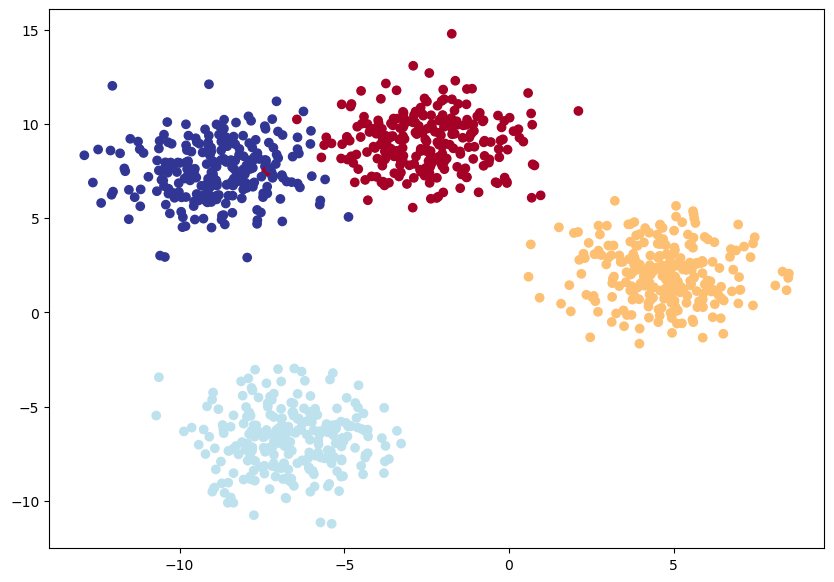

In [2]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Build Model

In [5]:
from torch import nn 

# Build model
class BlobModel(nn.Module):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    

model_4 = BlobModel(
    input_features=NUM_FEATURES, 
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)

model_4
    

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [15]:
# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [7]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.5614,  0.1213, -1.0201,  0.6101],
        [-2.3785, -1.4377, -2.6288,  1.1159],
        [ 0.1848, -0.1456,  2.2253, -0.9784],
        [-0.2271, -0.3450,  1.0201, -0.4382],
        [-2.0557, -1.2748, -2.0253,  0.8559]], grad_fn=<SliceBackward0>)

In [8]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [11]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2370, -0.0482, -1.3273,  0.7281],
        [-2.9914, -1.7829, -1.9291,  0.7255],
        [ 0.4247, -0.0097,  1.9127, -0.8070],
        [ 0.7088,  0.1902, -0.4617,  0.3560],
        [-1.9742, -1.2157, -2.8000,  1.2343]], grad_fn=<SliceBackward0>)
tensor([[0.2781, 0.2091, 0.0582, 0.4545],
        [0.0207, 0.0692, 0.0598, 0.8503],
        [0.1570, 0.1017, 0.6954, 0.0458],
        [0.3834, 0.2283, 0.1189, 0.2694],
        [0.0353, 0.0754, 0.0155, 0.8738]], grad_fn=<SliceBackward0>)


In [12]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [13]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2781, 0.2091, 0.0582, 0.4545], grad_fn=<SelectBackward0>)
tensor(3)


In [16]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.40861, Acc: 48.75% | Test Loss: 0.77523, Test Acc: 76.50%
Epoch: 10 | Loss: 0.18336, Acc: 99.00% | Test Loss: 0.16572, Test Acc: 99.00%
Epoch: 20 | Loss: 0.09336, Acc: 99.25% | Test Loss: 0.08424, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06516, Acc: 99.12% | Test Loss: 0.05718, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05223, Acc: 99.25% | Test Loss: 0.04436, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04501, Acc: 99.12% | Test Loss: 0.03702, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04045, Acc: 99.12% | Test Loss: 0.03231, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03735, Acc: 99.12% | Test Loss: 0.02904, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03511, Acc: 99.12% | Test Loss: 0.02664, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03344, Acc: 99.12% | Test Loss: 0.02480, Test Acc: 99.50%


In [17]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 6.4374e+00,  1.2111e+01, -1.2115e+01, -7.3050e+00],
        [ 2.1365e+00, -1.3892e+01,  1.3082e-01,  7.6128e+00],
        [-8.8421e+00, -1.5425e+01,  1.7167e+01,  8.8341e+00],
        [ 3.2979e+00,  8.8630e+00, -6.6275e+00, -5.3587e+00],
        [ 8.6304e+00,  3.9130e+00, -1.3653e+01, -2.7150e+00],
        [ 2.0626e+00, -1.7277e+01,  9.8573e-01,  9.5390e+00],
        [-8.5288e+00, -1.1763e+01,  1.5887e+01,  6.7426e+00],
        [ 6.7238e+00, -7.9272e-01, -9.7205e+00,  2.0567e-02],
        [-1.0015e+01, -2.1527e+01,  2.0289e+01,  1.2340e+01],
        [ 7.2938e+00,  9.2624e-01, -1.0965e+01, -9.7468e-01]])

In [18]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [20]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


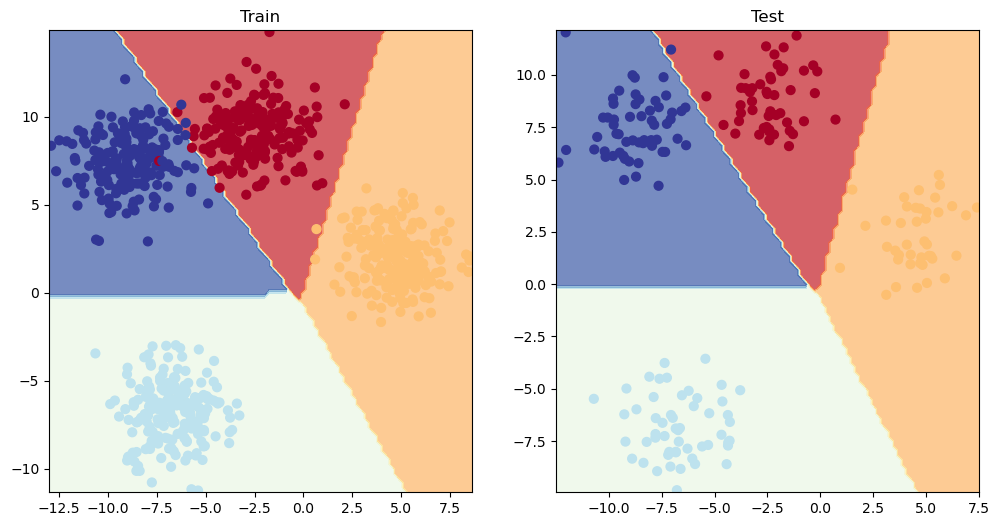

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)